In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj, get_rand_stays
from synthetic_data.plotting import plot_trajectory, add_plot_seg_boxes, add_plot_trajectory

from synthetic_data.trajectory_class import get_trajectory
from synthetic_data.trajectory import get_stay

dsec = 1/3600.0
t_total = np.arange(0,24,dsec)

In [9]:
time_thresh = 1/6
dist_thresh=0.25

# Synthetic data development: ensure travels are fast enough

Travels should not occur more slowly than 3.6 km/hr

In [10]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_

event_frac = rand_range(0.01,0.001, 1)[0]
duplicate_frac = 0.30 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}


In [13]:
time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

In [14]:
d_thresh_plot_buff = 0.5

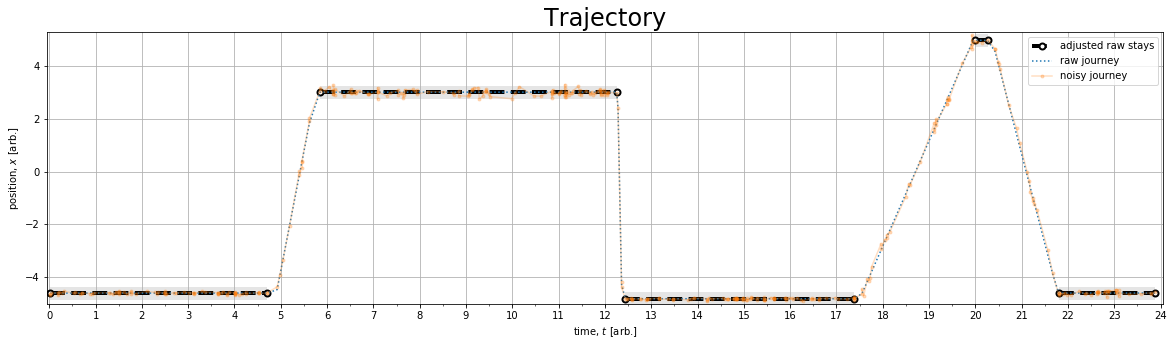

In [15]:
ylim = [noise_arr.min()-d_thresh_plot_buff*dist_thresh, noise_arr.max()+d_thresh_plot_buff*dist_thresh]

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_ylim(ylim);

In [17]:
from synthetic_data.trajectory_class import get_time_bounds, get_xlocs, get_stay

In [18]:
get_slope = lambda t1,x1,t2,x2: (x1-x2)/(t1-t2)

In [19]:
get_t_to  = lambda t1, x1, x2 ,m : np.sign(x2-x1)*(x2 - x1)/m + t1
get_t_fro = lambda t2, x1, x2 ,m : np.sign(x2-x1)*(x1 - x2)/m + t2

def get_rand_stays_x(configs, nr_stays=None):      
    """ 
    Creates a random set of stays.

    :param nr_stays: int A proposed count for the number of stays*
    
    :return: [dict] list of time-ordered stays
    
    *Note, due to the stochasticity and error checking, 
    this quantity may be larger than the actual number of stays returned
    """
    
    # Create a random number of stays
    #TODO s: 
    # 1. make this follow a non-uniform distribution 
    # 2. iterate until the corrected number of stays matches the proposed
    #    (this will be important when the distribution is specified)
    p,_ = np.histogram(np.random.lognormal(1.2,0.60,500),bins=np.arange(0,30,1), density=True)
    if nr_stays == None:
        nr_stays = np.random.choice(np.arange(p.size),size=1,p=p)[0]
    
    # flags to select whether the trajectory begins and ends on midnights
    m2m_flags = np.random.choice(np.arange(p.size),size=2)[0:2]%5 > 0
    
    print(m2m_flags)
    # Create the ordered timepoints for the stays
    #TODO: give the time thresh as a param
    t_bounds = get_time_bounds(nr_stays, configs['time_thresh'], m2m_flags)
    
    # Create the sptaial locations for the stays 
    #TODO: these should be specified in a config-file
    xlocs = get_xlocs(-2.0, 2.0, int(len(t_bounds)/2), configs['dist_thresh'])
    endpoints_flag = np.random.choice(np.arange(p.size),size=1,p=p)[0]%3
    if nr_stays <= 2:
        endpoints_flag = 2
    if endpoints_flag == 0:
        xlocs[0] = xlocs[-1]
    elif endpoints_flag == 1:
        xlocs[-1] = xlocs[0]
    else:
        pass
    
    # Adjust the t-bounds to account for at least minimal walking speeds
    min_speed = 3.6
    
    x_locs = []
    for xx in xlocs:
        x_locs.append(xx)
        x_locs.append(xx)
    
    for n in range(0,len(t_bounds)-2,2):
        
        m = get_slope(t_bounds[n+1], x_locs[n+1], t_bounds[n+2], x_locs[n+2])
        
        if abs(m) < 3.6:
            
            mid_t = (t_bounds[n+1] + t_bounds[n+2])/2.0
            mid_x = (x_locs[n+1] + x_locs[n+2])/2.0

            new_t1 = get_t_fro(mid_t, x_locs[n+1], mid_x, min_speed)
            new_t2  = get_t_to(mid_t, mid_x, x_locs[n+2], min_speed)            

            t_bounds[n+1] = new_t1
            t_bounds[n+2] = new_t2      

    
    # From the new times and locs, generate the stays
    #TODO: if checking against the proposed number of stays,
    #      apply the check above.
    stays = []
    for n in range(0,len(t_bounds)-1,2):
        #nn = 2*n
        stay = get_stay(t_bounds[n], t_bounds[n+1], x_locs[n+1])
        stays.append(stay) 
        
    return stays

[ True  True]


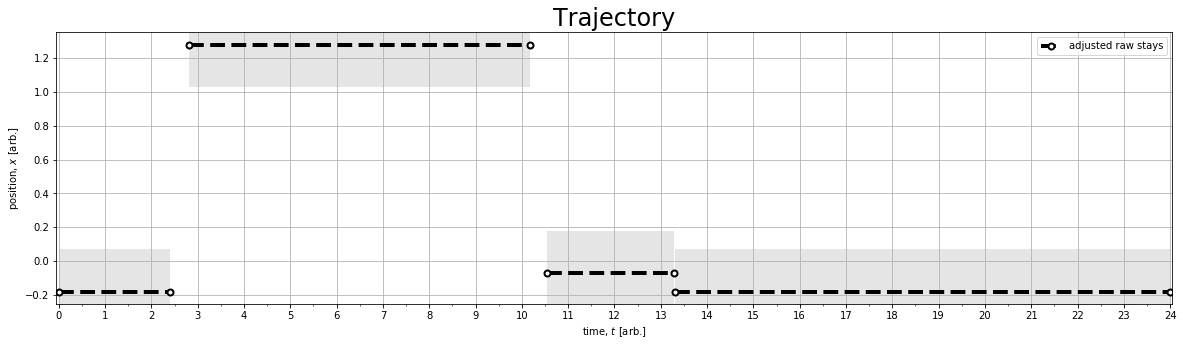

In [20]:
t_segs, x_segs = get_stay_segs(get_rand_stays_x(configs))

#ylim = [noise_arr.min()-d_thresh_plot_buff*dist_thresh, noise_arr.max()+d_thresh_plot_buff*dist_thresh]

ax = plot_trajectory(None, None, None, t_segs, x_segs, dist_thresh)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
#ax.set_ylim(ylim);

## Tests

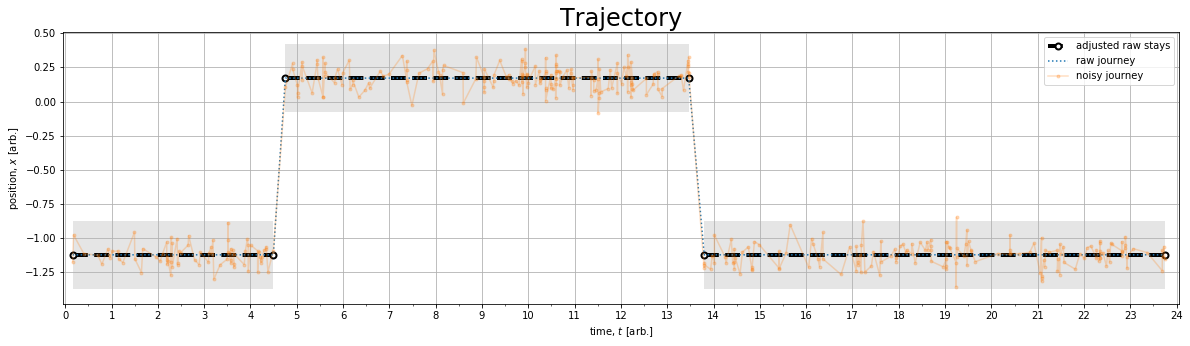

In [23]:

time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

ylim = [noise_arr.min()-d_thresh_plot_buff*dist_thresh, noise_arr.max()+d_thresh_plot_buff*dist_thresh]

ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, dist_thresh)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
ax.set_ylim(ylim);

## Multiple tests

In [24]:
rand_range = lambda min_, max_, size: (max_-min_)*np.random.random_sample(size=size) + min_


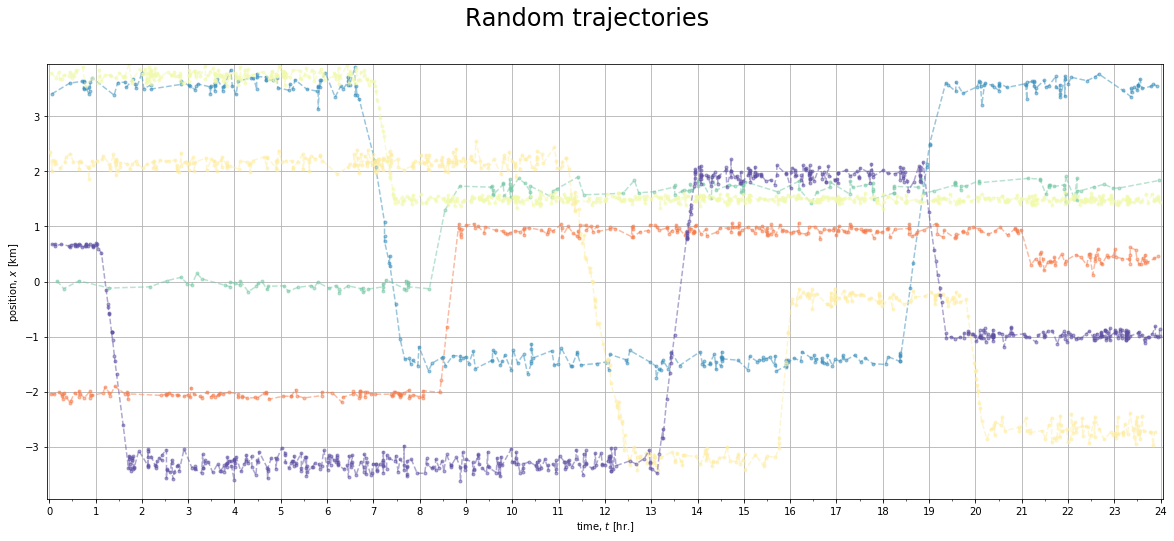

In [40]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(1,1,figsize=[20,8])

ylim = 0


for n in range(6):


    event_frac = rand_range(0.01,0.001, 1)[0]
    duplicate_frac = rand_range(0.05, 0.3, 1)[0]

    configs = {
        'time_thresh':1/6,
        'dist_thresh':0.5,
        'event_frac':event_frac,
        'duplicate_frac':duplicate_frac,    
        'noise_min':0.02,
        'noise_max':0.15
    }

    continuation = True
    while continuation:
        nn = 0
        try:
            t_arr, r_arr, x_arr, segments = get_rand_traj(configs)
            t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

            continuation = False
        except:
            print("Failed at", n, nn)
            if nn > 100: 
                continuation = False
            else:
                nn+=1
            pass    

    #ylim = [x_arr.min()-d_thresh_plot_buff*dist_thresh, x_arr.max()+d_thresh_plot_buff*dist_thresh]
    #ylim = [-1*ylimit-d_thresh_plot_buff*dist_thresh, ylimit+d_thresh_plot_buff*dist_thresh]
    
    ylim_ = max(np.abs(x_arr.min()),np.abs(x_arr.max()))
    ylim = max(ylim,ylim_)
    
    ax.plot(t_arr, x_arr, color=colors[n%len(colors)], marker='.', linestyle='--', lw=1.5, alpha=0.5)
    
plt.ylim([-1*ylim,ylim])

#plt.legend();

plt.xlabel(r'time, $t$ [hr.]')
plt.ylabel(r'position, $x$ [km]')



ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

ax.set_xlim(-0.05, 24.05)

ax.set_title('', fontsize=16)
ax.grid(visible=True);     
fig.suptitle("Random trajectories", fontsize=24);